In [2]:
import numpy as np
import os
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
from tensorflow.contrib.layers import variance_scaling_initializer
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.data import Dataset, Iterator
from sklearn.metrics import f1_score, classification_report
import datetime
import pickle
from nltk.tokenize import TweetTokenizer
import pandas as pd
import re
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
###### Do not modify here ###### 
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    #strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
###### Do not modify  here ######

###### Do not modify here ###### 

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)



## Data Preparing

In [3]:
tknzr = TweetTokenizer()

def filter_tweet(tweet, token = tknzr):
    tweet = re.sub('https?:\/\/\S+','URLTOK',tweet.lower().strip()) # url
    tweet = re.sub('@(?:[a-zA-Z]+|[0-9 \/]+)', '<M>', tweet) # mention
    tweet = re.sub('#(?:[a-zA-Z]+|[0-9 \/]+)', '<H>', tweet) # hashtag
    tweet = re.sub('(\:|\=)(?:\)|\-|\(|D| )+', '', tweet) # emoticon
    return token.tokenize(tweet) # return tokenized



### Load positive data

#### Negative Tweets

In [3]:
with open('data/distance_supervised/sad') as f:
    sad_tweet = [filter_tweet(line) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_2_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_3_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]
print(len(sad_tweet))


1252941


#### Positive Tweets

In [4]:
with open('data/distance_supervised/smile') as f:
    smile_tweet = [filter_tweet(line) for line in f.readlines()][:len(sad_tweet)]
len(smile_tweet)

1252941

In [14]:
# size filter
max_length = 60

In [6]:


sad_tweet = list(filter(lambda tweet: len(tweet) <= max_length, sad_tweet))
print(len(sad_tweet))
smile_tweet = list(filter(lambda tweet: len(tweet) <= max_length, smile_tweet))
print(len(smile_tweet))

1252213
1252910


### Build Dictionary

In [7]:
from collections import defaultdict
vocabulary_dict = {}
word_index = 0

for tweet in smile_tweet+sad_tweet:
    for word in tweet:
        if word not in vocabulary_dict:
            vocabulary_dict[word] = word_index
            word_index +=1

In [85]:
vocabulary_dict['<m>'] = vocabulary_dict.get('<M>')
vocabulary_dict['<h>'] = vocabulary_dict.get('<h>')
vocabulary_dict['urltok'] = vocabulary_dict.get('URLTOK')

In [77]:
print(vocabulary_dict.get('URLTOK'))
print(vocabulary_dict.get('<M>'))
print(vocabulary_dict.get('<H>'))

349883
349896
170


In [4]:
# transform the tweet sentence to numerical representation
def word_transform(tweet_set, max_length = 60):
    set_array = []
    for tweet in tweet_set:
        tweet_array = [0] * max_length
        for i, word in enumerate(tweet):
            if i == 60: break # remove the words after 60th
            if vocabulary_dict.get(word):
                tweet_array[i] = vocabulary_dict[word]
            else:
                tweet_array[i] = 0
        set_array.append(tweet_array)
    return np.array(set_array)

In [10]:
sad_array = word_transform(sad_tweet, max_length = max_length)
print(sad_array.shape)
smile_array = word_transform(smile_tweet, max_length = max_length)
print(smile_array.shape)

(1252213, 60)
(1252910, 60)


In [11]:
smile_array[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 18, 21,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [12]:
sad_array[0]

array([325, 401,  73, 196,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

In [13]:
total_tweets = np.concatenate((smile_array[:sad_array.shape[0]], sad_array), axis=0)
total_labels = np.concatenate((np.zeros(sad_array.shape[0]), np.ones(sad_array.shape[0])), axis=0)

## Prepare Training + Testing Data

In [14]:
# from sklearn.model_selection import ShuffleSplit
# rs = ShuffleSplit(n_splits=1, test_size=.1, random_state=0)

# senti_train = en_train['label'].as_matrix()
# senti_test  = en_test['label'].as_matrix()

# for train_index, test_index in rs.split(senti):
#     X_train = tweets[train_index]
#     y_train = senti[train_index]

#     X_test = tweets[test_index]
#     y_test = senti[test_index]
# X_train.shape

from sklearn.utils import shuffle
X_train, y_train = shuffle(total_tweets, total_labels, random_state=8)

y_train

array([ 1.,  1.,  0., ...,  0.,  1.,  1.])

# Load Pretrain Word2Vec Model (#DIM 52)

In [15]:
# Load pre train Word2vec
wb_matrix = np.load("data/embedding/en_word2vec_52.npy")
print(wb_matrix.shape)
vocabulary_dict_ = pickle.load(open("data/embedding/vocabulary_dict_52.pickle", "rb"))
print(len(vocabulary_dict))

(9770612, 52)
496788


In [16]:
len(pickle.load(open("data/embedding/vocabulary_dict_52.pickle", "rb")))

9770611

In [17]:
print(vocabulary_dict.get('URLTOK'))
print(vocabulary_dict_.get('URLTOK'))

349883
None


In [18]:
 # initial matrix with random uniform
initW = np.random.uniform(-0.25,0.25,(len(vocabulary_dict), wb_matrix.shape[1]))
# load any vectors from the word2vec
for word, index in vocabulary_dict.items():
#     print(word)
#     print(index)
    idx = vocabulary_dict_.get(word)
#     print(idx)
    
    if idx != 0 and idx is not None:
        initW[index] = wb_matrix[idx]
        
initW.shape

(496788, 52)

# Distance Supervised Learning

In [44]:
n_input = max_length
n_output = 2
learning_rate = 1

embedding_size = initW.shape[1]
filter_sizes = [4,3]
num_filters = 200
pooling_size = 4
pooling_strides = 2
epochs_num = 20
batch_size = 128

In [21]:
def data_iterator():
    """ A simple data iterator """
    batch_idx = 0
    while True:
        for batch_idx in range(0, len(X_train), batch_size):
            trains_batch = X_train[batch_idx:batch_idx+batch_size]
            labels_batch = y_train[batch_idx:batch_idx+batch_size]
            yield trains_batch, labels_batch


iter_ = data_iterator()

In [42]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
# mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = initW.shape),
                    trainable=True, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], initW.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 1], strides=2)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[27, 1], strides=1)

# Dense Layer, Combine all the pooled features
pool2_flat = tf.reshape(pool2, [-1, num_filters])

dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, name = "Fully_connect")
# dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode)

# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
                         activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Softmax")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


In [22]:
# prepare the training batch
# train_data = tf.contrib.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).repeat()
# train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
# train_next_batch = train_iterator.get_next()

In [45]:
round_of_epochs = int(X_train.shape[0]/batch_size)
print(round_of_epochs)

saver = tf.train.Saver() # to store the model

with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    sess.run(word2vec.assign(initW))# Assign the pretrain word2vec
    for _ in range(epochs_num):
        for _ in range(round_of_epochs):
#             train, label = sess.run(train_next_batch) # Get the mini-batch data sample
            train, label = next(iter_)
            sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train

        
    distance_supervised_embeddings = sess.run(word2vec)
    

19565


## Distance Supervised Learning Comparsion

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [47]:
def draw_plot(words, matrix, v_dic, nbest=15):
    word_vectors = []
    for word in words:
        index = v_dic[word]
        word_vectors.append(matrix[index])  
    pca = PCA(n_components=2)  
    pca.fit(word_vectors)
    X = pca.transform(word_vectors)
    
    xs = X[:, 0]
    ys = X[:, 1]

    # draw
    plt.figure(figsize=(12,8))
    plt.scatter(xs, ys, marker = 'o')
    for i, w in enumerate(words):
        plt.annotate(w, (xs[i], ys[i]))

    plt.show()

Word2vec with distance supervised learning

Before


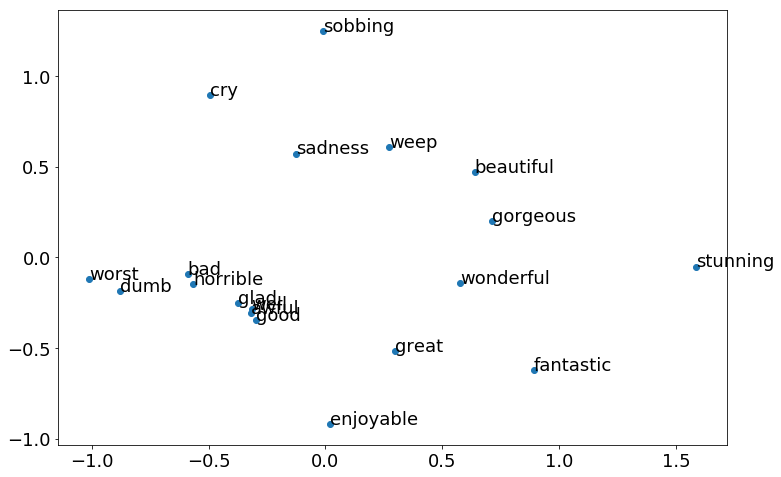

After


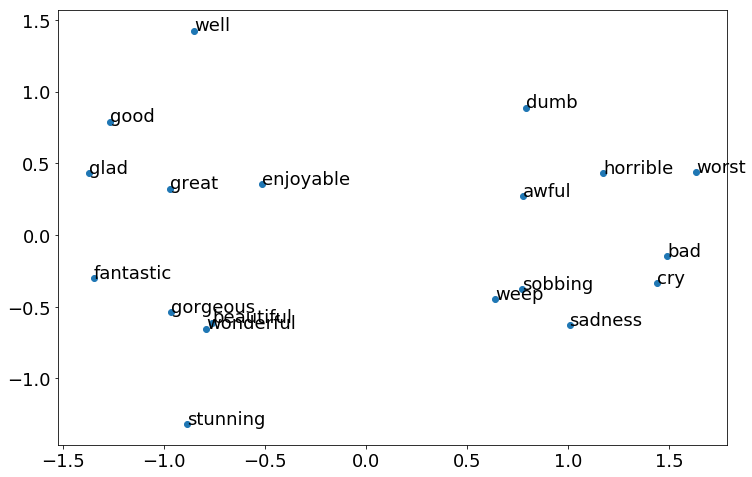

In [75]:
words = ['sadness', 'sobbing', 'cry', 'weep', 'horrible', 'worst', 'awful', 'enjoyable', 'wonderful',
         'bad', 'fantastic', 'great', 'good', 'beautiful', 'stunning','gorgeous','glad','well','dumb']

plt.rcParams['font.size'] = 18

print("Word2vec with distance supervised learning\n")
print("Before")
draw_plot(words, wb_matrix, vocabulary_dict_)
print("After")
draw_plot(words, distance_supervised_embeddings, vocabulary_dict)

In [76]:
del wb_matrix, vocabulary_dict_, X_train, y_train, smile_array, smile_tweet, sad_array, sad_tweet

### Dump model

In [49]:
np.save('data/embedding/distance_supervised_2M', distance_supervised_embeddings)
with open('data/embedding/distance_supervised_2M.pickle', 'wb') as f:
    pickle.dump(vocabulary_dict,f)

### Load model

In [5]:
# Load pre train Word2vec
distance_supervised_embeddings = np.load("data/embedding/distance_supervised_2M.npy")
print(distance_supervised_embeddings.shape)
vocabulary_dict = pickle.load(open("data/embedding/distance_supervised_2M.pickle", "rb"))
print(len(vocabulary_dict))

(496788, 52)
496788


# Supervised Learning

In [6]:
def emotion2label(emo):
    if emo =='joy':            return 0
    elif emo =='anticipation': return 1
    elif emo =='trust':        return 2
    elif emo =='surprise':     return 3
    elif emo =='sadness':      return 4
    elif emo =='fear':         return 5
    elif emo =='anger':        return 6
    elif emo =='disgust':      return 7

In [7]:
# Load Training data
en_train = pd.read_csv('data/emo/Train/train.tsv', delimiter='\t', names=["emotion", "tweet"])
en_train.head()



,emotion,tweet
0,anticipation,<M>: <H> <H> <H> <H> <H> <H> <M> ... You DTM. ...
1,anger,stop posting every damn thing you do on instag...
2,trust,<H> youll never meet justin bieber. hell never...
3,anticipation,<H> &amp; count down the days until May! <H> <...
4,surprise,<M> Holme upon Spalding moor won rock challeng...


In [8]:

# Load Testing data
en_test = pd.read_csv('data/emo/Test/test.tsv', delimiter='\t',names=["tweet","emotion", "emotion2", "emotion3"])
en_test.head()

,tweet,emotion,emotion2,emotion3
0,#championsleague i am cmng to watch you...all ...,joy,anticipation,trust
1,#mufc wages up19% in13/14 season with #dimaria...,anticipation,fear,NaN
2,#sterlings getting some great experience here....,joy,trust,anticipation
3,1 more week then it's block 208 kop grandstand...,anticipation,joy,trust
4,1 week from today! the @championsleague return...,anticipation,joy,trust


In [9]:
en_train['label'] = en_train['emotion'].map(emotion2label)
en_train.head()


,emotion,tweet,label
0,anticipation,<M>: <H> <H> <H> <H> <H> <H> <M> ... You DTM. ...,1
1,anger,stop posting every damn thing you do on instag...,6
2,trust,<H> youll never meet justin bieber. hell never...,2
3,anticipation,<H> &amp; count down the days until May! <H> <...,1
4,surprise,<M> Holme upon Spalding moor won rock challeng...,3


In [10]:

en_test['label'] = en_test['emotion'].map(emotion2label).fillna(-1).astype('int')
en_test['label2'] = en_test['emotion2'].map(emotion2label).fillna(-1).astype('int')
en_test['label3'] = en_test['emotion3'].map(emotion2label).fillna(-1).astype('int')
en_test.head()

,tweet,emotion,emotion2,emotion3,label,label2,label3
0,#championsleague i am cmng to watch you...all ...,joy,anticipation,trust,0,1,2
1,#mufc wages up19% in13/14 season with #dimaria...,anticipation,fear,NaN,1,5,-1
2,#sterlings getting some great experience here....,joy,trust,anticipation,0,2,1
3,1 more week then it's block 208 kop grandstand...,anticipation,joy,trust,1,0,2
4,1 week from today! the @championsleague return...,anticipation,joy,trust,1,0,2


In [11]:
train_tweet = [filter_tweet(tweet) for tweet in en_train['tweet']]
test_tweet = [filter_tweet(tweet) for tweet in en_test['tweet']]


print(len(train_tweet))
print(len(test_tweet))

1965870
1954


In [15]:

tweets_train_all = word_transform(train_tweet, max_length = max_length)
print(tweets_train_all.shape)
tweets_test = word_transform(test_tweet, max_length = max_length)
print(tweets_test.shape)

senti_train_all = en_train['label'].as_matrix()
senti_test  = en_test['label'].as_matrix()

(1965870, 60)
(1954, 60)


### Train Validation Split 

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
tweets_train, tweets_valid, senti_train, senti_valid = train_test_split(tweets_train_all, senti_train_all, test_size=0.1, random_state=42)
print(tweets_train.shape)
print(tweets_valid.shape)

(1769283, 60)
(196587, 60)


### Build Model

In [55]:
n_input = max_length
n_output = 8
learning_rate = 1

embedding_size = distance_supervised_embeddings.shape[1]
filter_sizes = [4,3]
num_filters = 300
pooling_size = 4
pooling_strides = 2
epochs_num = 5
batch_size = 64

In [56]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
# mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = distance_supervised_embeddings.shape),
                    trainable=False, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], distance_supervised_embeddings.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 1], strides=2)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[27, 1], strides=1)

# Dense Layer, Combine all the pooled features
pool2_flat = tf.reshape(pool2, [-1, num_filters])

dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, name = "Fully_connect")
# dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode)

# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
                         activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Softmax")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


In [57]:
# # prepare the training batch in tensorflow
# train_data = tf.contrib.data.Dataset.from_tensor_slices((tweets_train, senti_train)).batch(batch_size).repeat()
# train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
# train_next_batch = train_iterator.get_next()

In [58]:
# prepare the training batch in python

def data_iterator(X, y):
    """ A simple data iterator """
    batch_idx = 0
    while True:
        for batch_idx in range(0, len(X), batch_size):
            trains_batch = X[batch_idx:batch_idx+batch_size]
            labels_batch = y[batch_idx:batch_idx+batch_size]
            yield trains_batch, labels_batch


iter_ = data_iterator(tweets_train, senti_train)

valid_iter_ = data_iterator(tweets_valid, senti_valid)

In [60]:
import os
os.makedirs("./model")

In [72]:
round_of_epochs = int(tweets_train.shape[0]/batch_size)
valid_rounds_of_epochs = int(tweets_valid.shape[0]/batch_size)

train_loss = []
test_loss  = []

train_f1 = []
test_f1 = []
x_axis = np.arange(0., epochs_num, 1)
saver = tf.train.Saver() # to store the model

best_valid_acc = 0

with tf.Session() as sess:
    # Initialize all variables
    if os.path.exists('./model/emo_504.ckpt.meta'):
        print ("Model Restore")
        saver.restore(sess, './model/emo_504.ckpt')
    else:
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())
        sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
#             train, label = sess.run(train_next_batch) # Get the mini-batch data sample from tensorflow
            train, label = next(iter_) # Get the mini-batch data sample from tensorflow

            sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train

        # An epoch finish
        
        loss, pred, acc = sess.run([cross_entropy, predicted_class, accuracy], feed_dict={X:train, y:label})
        
        # Validation
        valid_loss_list = []
        predict_res = np.zeros(batch_size)
        t_label = np.zeros(batch_size)
        valid_acc_list = []
        for _ in range(valid_rounds_of_epochs):
            x_valid, y_valid = next(valid_iter_) # Get the mini-batch data sample from tensorflow
            t_loss, t_pred, t_accuracy = sess.run([cross_entropy, predicted_class, accuracy], feed_dict={X:x_valid, y:y_valid})
            valid_loss_list.append(t_loss)
            predict_res = np.concatenate((predict_res, t_pred))
            t_label = np.concatenate((t_label, y_valid))
            valid_acc_list.append(t_accuracy)
        # An epoch finish
#         t_loss, t_pred = sess.run([cross_entropy,predicted_class], feed_dict={X:tweets_valid, y:senti_valid})
        train_loss.append(loss)
        test_loss.append(sum(valid_loss_list)/len(valid_loss_list))
        train_f1.append(f1_score(label, pred, average='weighted'))
        test_f1.append(f1_score(t_label[1:], predict_res[1:], average='weighted'))
        
        t_acc = sum(valid_acc_list)/len(valid_acc_list)
        print("{} - {:3d} epoch, loss:{:.3f}, accuracy:{:.3f}/{:.3f}, f1-score:{:.3f}/{:.3f}".format(
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            epochs+1,
            loss, 
            acc,
            t_acc,
            f1_score(label, pred, average='weighted'),
            f1_score(t_label[1:], predict_res[1:], average='weighted')
            )
        )
        
        if best_valid_acc < t_acc:
            best_valid_acc = t_acc
            save_path = saver.save(sess, "./model/emo_"+str(t_acc)[2:5]+".ckpt")
        
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, test_loss, 'b')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, test_f1)
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.show()

    

ValueError: At least two variables have the same name: Convolution_1st/kernel

In [67]:
# restore graph
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./model/emo_504.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./model/'))
    sess.run(tf.global_variables_initializer())
    

INFO:tensorflow:Restoring parameters from ./model/emo_504.ckpt
16
